In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Dropout, SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
maotai = pd.read_csv("./SH600519.csv")  # 读取股票文件

training_set = maotai.iloc[0:2426 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[2426-300: , 2:3].values

In [8]:
# 归一化
sc = MinMaxScaler(feature_range=(0,1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set = sc.fit_transform(test_set)

In [10]:
training_set_scaled

array([[0.4523692 ],
       [0.45964956],
       [0.4643386 ],
       ...,
       [0.05923001],
       [0.06663376],
       [0.06910168]])

In [15]:
x_train, y_train = [], []
x_test, y_test = [], []

In [16]:
# 利用for循环，遍历整个训练集，提取训练集中连续60天的开盘价作为输入特征x_train，第61天的数据作为标签，for循环共构建2426-300-60=2066组数据。
for i in range(60,len(training_set_scaled)):
    x_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

In [17]:
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即2066组数据；输入60个开盘价，预测出第61天的开盘价，循环核时间展开步数为60; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (len(x_train), 60, 1))
y_train = np.array(y_train)

In [18]:
for i in range(60 , len(test_set)):
    x_test.append(test_set[i-60:i,0])
    y_test.append(test_set[i, 0])

x_test = np.reshape(x_test,(len(x_test),60,1))
y_test = np.array(y_test)

In [20]:
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss = 'mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值

model_savepath = "./maotai_stock_checkpoint/rnn_stock.ckpt"

if os.path.exists(model_savepath+'.index'):
    print("======================load model=======================")
    model.load_weights(model_savepath)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_savepath,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=64,epochs=50, validation_data=(x_test, y_test),validation_freq=1,
                   callbacks=[cp_callback])

model.summary()

Epoch 1/50
33/33 [==============================] - 2s 26ms/step - loss: 0.2721 - val_loss: 0.0184
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.0286- ETA: 0s - loss: - 1s 18ms/step - loss: 0.0285 - val_loss: 0.0133
Epoch 3/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0160 - val_loss: 0.0089- ETA: 0s - loss: 0.
Epoch 4/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0112 - val_loss: 0.0080
Epoch 5/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0096 - val_loss: 0.0062
Epoch 6/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 7/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 8/50
33/33 [==============================] - 1s 18ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 9/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 10/50
33/33 [============================

In [23]:
with open("./maotai_stock_weights.txt", 'w') as f:
    for v in model.trainable_variables:
        f.write(str(v.name)+'\n')
        f.write(str(v.shape)+'\n')
        f.write(str(v.numpy())+'\n')

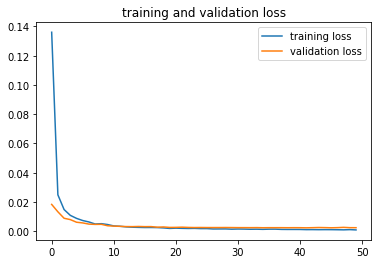

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title("training and validation loss")
plt.legend()
plt.show()

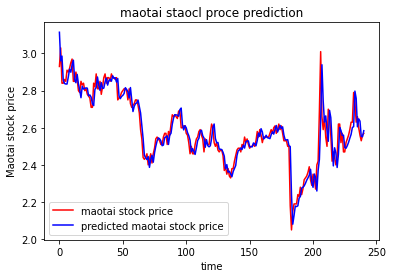

In [26]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc.inverse_transform(test_set[60:])

plt.plot(real_stock_price, color='red', label='maotai stock price')
plt.plot(predicted_stock_price, color='blue', label='predicted maotai stock price')
plt.title("maotai staocl proce prediction")
plt.xlabel("time")
plt.ylabel("Maotai stock price")
plt.legend()
plt.show()

In [27]:
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mse)
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)


均方误差: 0.004321
均方根误差: 0.065731
平均绝对误差: 0.042905


In [30]:
print(history.history)

{'loss': [0.13601800799369812, 0.024911755695939064, 0.014838560484349728, 0.010873634368181229, 0.008822268806397915, 0.007336225360631943, 0.006359804887324572, 0.00495923962444067, 0.005187851842492819, 0.004602258093655109, 0.0036488529294729233, 0.003424456575885415, 0.0029852772131562233, 0.0027721894439309835, 0.0026612814981490374, 0.0025629126466810703, 0.0025855826679617167, 0.0025219013914465904, 0.0022951364517211914, 0.0019504541996866465, 0.002127106999978423, 0.0020006047561764717, 0.0019139255164191127, 0.001978879561647773, 0.001818982302211225, 0.0018198308534920216, 0.001570081920363009, 0.0015917078126221895, 0.001608360675163567, 0.001437319559045136, 0.0015484885079786181, 0.0014920494286343455, 0.0013779106084257364, 0.0014278965536504984, 0.001316042966209352, 0.0014444664120674133, 0.0014561408897861838, 0.0012802202254533768, 0.0012442957377061248, 0.0012487706262618303, 0.0012367927702143788, 0.001120000146329403, 0.0011402753880247474, 0.001089946017600596, 